# Likelihood Ratio

The likelihood ratio quantifies **how much more probable our observed data** is under one model compared to another, providing a natural way to choose between competing explanations of the data.

# Graphical Summary

![Fig](./graphical_summary/slides/Slide21.png)

# Key Formula

The likelihood ratio between Model 1 and Model 2 is:

$$
\text{LR} = \frac{\mathcal{L}(\text{M}_1 \mid \text{D})}{\mathcal{L}(\text{M}_2 \mid \text{D})}
$$

Where:
- $\text{LR}$ is the likelihood ratio
- $\text{D}$ represents the observed data
- $\mathcal{L}(\text{M}_1 \mid \text{D})$ is the likelihood function for Model 1 $\text{M}_1$ given data $\text{D}$
- $\mathcal{L}(\text{M}_2 \mid \text{D})$ is the likelihood function for Model 2 $\text{M}_2$ given data $\text{D}$


# Technical Details

## Basic Interpretation

For the likelihood ratio ($\text{LR}$):
- $\text{LR} > 1$: Model 1 better explains the data
- $\text{LR} < 1$: Model 2 better explains the data
- $\text{LR} = 1$: Both models explain the data equally well

The likelihood ratio quantifies the relative evidence for one model compared to another, providing a direct way to compare competing hypotheses based on the observed data.


## Properties

- The likelihood ratio is always non-negative (because likelihood is always between 0 and 1): $\text{LR} \geq 0$
- Can be used to compare any two models
- Forms the basis for many statistical tests and model selection criteria, e.g., testing association between variants and traits

## Wilks' Theorem

Let’s assume we are dealing with models parameterized by $\theta$. To generalize the case of simple hypotheses, let’s assume that $H_0$ specifies that $\theta$ lives in some set $\Theta_0$ and $H_1$ specifies that $\theta \in \Theta_1$. Let $\Omega = \Theta_0 \cup \Theta_1$. A somewhat natural extension to the likelihood ratio test statistic we discussed above is the generalized log-likelihood ratio:

$$
\Lambda^* = \log \frac{\max_{\theta \in \Theta_1} \mathcal{L}(\theta)}{\max_{\theta \in \Theta_0} \mathcal{L}(\theta)} 
$$


For technical reasons, it is preferable to use the following related quantity:

$$
\Lambda_n = 2 \log \frac{\max_{\theta \in \Omega} \mathcal{L}(\theta)}{\max_{\theta \in \Theta_0} \mathcal{L}\theta}
$$

Just like before, larger values of $\Lambda_n$ provide stronger evidence against $H_0$.

**Wilks's Theorem** states that, suppose that the dimension of $\Omega$ is $v$ and the dimension of $\Theta_0$ is $r$. Under regularity conditions and assuming $H_0$ is true, the distribution of $\Lambda_n$ tends to a chi-squared distribution with degrees of freedom equal to $v−r$ as the sample size tends to infinity.

With this theorem in hand (and for $n$ large), we can compare the value of our log-likehood ratio to the expected values from a $\chi^2_{v−r}$ distribution.


## Likelihood Ratio Test

The likelihood ratio test (LRT) compares nested models to test whether a more complex model provides a significantly better fit than a simpler one.

**Test Statistic:**

$$
\Lambda = -2 \log \left( \frac{\mathcal{L}(\text{M}_0 \mid \text{D})}{\mathcal{L}(\text{M}_1 \mid \text{D})} \right) = -2[\ell(\text{M}_0 \mid \text{D}) - \ell(\text{M}_1 \mid \text{D})]
$$

where $\text{M}_0$ is the null (simpler) model and $\text{M}_1$ is the alternative (more complex) model.

According to **Wilks' Theorem**, under regularity conditions, $\Lambda$ asymptotically follows $\chi^2_{\text{df}}$ where $\text{df}$ is the difference in the number of parameters between the two models. Given significance level $\alpha$, reject $H_0$ if $\Lambda > \chi^2_{\text{df},\alpha}$.

**Key Limitations:**

- **Nested models required** – Cannot compare non-nested models
  - *Counterexample*: Comparing different genetic variants (Variant A vs. Variant B) is invalid because neither model is a subset of the other (i.e., **non-nested**)
  - You can compute the likelihood ratio, but you cannot conduct a valid likelihood ratio test
- **Asymptotic approximation** – May perform poorly with small sample sizes
- **Regularity conditions** – Must be satisfied for chi-square approximation to hold
- **Multiple testing** – Requires correction when performing many simultaneous tests

# Related Topics

- [ordinary least squares](https://statfungen.github.io/statgen-primer/ordinary_least_squares.html)
- [summary statistics](https://statfungen.github.io/statgen-primer/summary_statistics.html)
- [likelihood](https://statfungen.github.io/statgen-primer/likelihood.html)
- [maximum likelihood estimation](https://statfungen.github.io/statgen-primer/maximum_likelihood_estimation.html)

# Example

In [Lecture: likelihood](https://statfungen.github.io/statgen-primer/likelihood.html), we compared three genetic effect models using likelihood. Now we extend this analysis to answer: **Is the observed effect statistically significant, or just random noise?**

Using the same genetic data (true effect $\beta = 0.4$), we'll:
1. Compare models using **likelihood ratios**
2. Find the optimal parameter via **maximum likelihood estimation** 
3. Test significance using the **likelihood ratio test**

This pipeline demonstrates the complete workflow from parameter estimation to hypothesis testing.

## Setup

Let's first generate the genotype data and trait values for 5 individuals.


In [1]:
# Clear the environment
rm(list = ls())
library(ggplot2)
set.seed(19)  # For reproducibility

# Generate genotype data for 5 individuals at a single variant
N <- 5
genotypes <- c("CC", "CT", "TT", "CT", "CC")  # Individual genotypes
names(genotypes) <- paste("Individual", 1:N)

# Define alternative allele
alt_allele <- "T"

# Convert to additive genotype coding (count of alternative alleles)
Xraw_additive <- numeric(N)
for (i in 1:N) {
  alleles <- strsplit(genotypes[i], "")[[1]]
  Xraw_additive[i] <- sum(alleles == alt_allele)
}
names(Xraw_additive) <- names(genotypes)

# Standardize genotypes
X <- scale(Xraw_additive, center = TRUE, scale = TRUE)[,1]

# Set true beta and generate phenotype data
true_beta <- 0.4
true_sd <- 1.0

# Generate phenotype with true effect
Y <- X * true_beta + rnorm(N, 0, true_sd)

## Likelihood and Log-likelihood

Now, let's create two functions to compute the likelihood and log-likelihood under different models (in this case, different $\beta$s) for the effect of a genetic variant on the phenotype:


In [2]:
# Likelihood function for normal distribution
likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  # Calculate likelihood (product of normal densities)
  prod(dnorm(Y, mean = mu, sd = sd, log = FALSE))
}

# Log-likelihood function (more numerically stable)
log_likelihood <- function(beta, sd, X, Y) {
  # Calculate expected values under the model
  mu <- X * beta
  # Calculate log-likelihood (sum of log normal densities)
  sum(dnorm(Y, mean = mu, sd = sd, log = TRUE))
}


Now, let's apply this function to our three models:


In [3]:
# Test three different models with different beta values
beta_values <- c(0, 0.5, 1.0)  # Three different effect sizes to test
model_names <- paste0("Model ", 1:3, " (beta = ", beta_values, ")")

# Calculate likelihoods and log-likelihoods
results <- data.frame(
  Model = model_names,
  Beta = beta_values,
  Likelihood = numeric(3),
  Log_Likelihood = numeric(3)
)

for (i in 1:3) {
  results$Likelihood[i] <- likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
  results$Log_Likelihood[i] <- log_likelihood(beta = beta_values[i], sd = true_sd, X = X, Y = Y)
}

print("Likelihood and Log-Likelihood Results:")
results

[1] "Likelihood and Log-Likelihood Results:"


Model,Beta,Likelihood,Log_Likelihood
<chr>,<dbl>,<dbl>,<dbl>
Model 1 (beta = 0),0.0,0.0019210299,-6.254894
Model 2 (beta = 0.5),0.5,0.0021961524,-6.121048
Model 3 (beta = 1),1.0,0.0009236263,-6.987203


Now let's calculate the likelihood ratios between each pair of models:


In [4]:
# Calculate all pairwise likelihood ratios
model_pairs <- combn(1:3, 2)  # All combinations of 2 models from 3
n_pairs <- ncol(model_pairs)

lr_results <- data.frame(
  Comparison = character(n_pairs),
  LR = numeric(n_pairs),
  Log_LR = numeric(n_pairs),
  Interpretation = character(n_pairs),
  stringsAsFactors = FALSE
)

for (i in 1:n_pairs) {
  m1 <- model_pairs[1, i]  # First model index
  m2 <- model_pairs[2, i]  # Second model index
  
  # Calculate likelihood ratio: L(M1|D) / L(M2|D)
  lr_value <- results$Likelihood[m1] / results$Likelihood[m2]
  log_lr_value <- results$Log_Likelihood[m1] - results$Log_Likelihood[m2]
  
  # Determine interpretation
  if (lr_value > 1) {
    interpretation <- paste("Model", m1, "better supported")
  } else if (lr_value < 1) {
    interpretation <- paste("Model", m2, "better supported")
  } else {
    interpretation <- "Equal support"
  }
  
  # Store results
  lr_results$Comparison[i] <- paste("Model", m1, "vs Model", m2)
  lr_results$LR[i] <- lr_value
  lr_results$Log_LR[i] <- log_lr_value
  lr_results$Interpretation[i] <- interpretation
}

The results are:

In [5]:
lr_results

Comparison,LR,Log_LR,Interpretation
<chr>,<dbl>,<dbl>,<chr>
Model 1 vs Model 2,0.8747253,-0.1338454,Model 2 better supported
Model 1 vs Model 3,2.0798778,0.7323091,Model 1 better supported
Model 2 vs Model 3,2.3777498,0.8661546,Model 2 better supported


The likelihood ratios reveal clear patterns in model support:

- **Model 2** ($\beta = 0.5$) receives strongest support, being 1.14× more likely than Model 1 and 2.38× more likely than Model 3
- **Model 1** ($\beta = 0$) is 2.08× more likely than Model 3 ($\beta = 1.0$), suggesting no effect is more plausible than a large effect

This ranking makes sense given the true effect ($\beta = 0.4$) used to generate the data: Model 2 is closest to the truth, followed by Model 1, while Model 3 substantially overestimates the genetic effect.

## Likelihood Ratio Test

From our results, we see that Model 2 ($\beta$ = 0.5) has the highest likelihood among our three tested values. But for a proper likelihood ratio test, we need to compare the null hypothesis ($\beta$ = 0) against the best possible alternative - which means we need to find the Maximum Likelihood Estimate (MLE).

The LRT framework is:
- $H_0$: $\beta = 0$ (no genetic effect)
- $H_1$: $\beta \neq 0$ (genetic effect exists - best estimate is the MLE)


In [6]:
# First, find the MLE to get the best possible alternative model
mle_result <- optimize(log_likelihood, 
                       interval = c(-2, 2), 
                       maximum = TRUE,
                       sd = true_sd, X = X, Y = Y)

beta_mle <- mle_result$maximum
log_lik_mle <- mle_result$objective

cat("MLE: beta =", round(beta_mle, 4), "\n")
cat("Log-likelihood at MLE:", round(log_lik_mle, 4), "\n")

MLE: beta = 0.3169 
Log-likelihood at MLE: -6.054 


Now we can conduct the LRT:

In [7]:
# Now conduct the LRT: MLE vs Null
log_lik_null <- log_likelihood(beta = 0, sd = true_sd, X = X, Y = Y)

cat("\nLikelihood Ratio Test:\n")
cat("H0: beta = 0\n")
cat("H1: beta != 0 (MLE)\n\n")

# Calculate LRT statistic
lrt_statistic <- -2 * (log_lik_null - log_lik_mle)
df <- 1  # difference in number of free parameters

# Calculate p-value
p_value <- pchisq(lrt_statistic, df = df, lower.tail = FALSE)

cat("Log-likelihood (Null):", round(log_lik_null, 4), "\n")
cat("Log-likelihood (MLE):", round(log_lik_mle, 4), "\n")
cat("LRT Statistic:", round(lrt_statistic, 4), "\n")
cat("p-value:", round(p_value, 4), "\n")

# Statistical decision
alpha <- 0.05
if (p_value < alpha) {
  cat("Result: REJECT null - significant evidence for genetic effect\n")
} else {
  cat("Result: FAIL TO REJECT null - insufficient evidence for genetic effect\n")
}


Likelihood Ratio Test:
H0: beta = 0
H1: beta != 0 (MLE)

Log-likelihood (Null): -6.2549 
Log-likelihood (MLE): -6.054 
LRT Statistic: 0.4018 
p-value: 0.5262 
Result: FAIL TO REJECT null - insufficient evidence for genetic effect


Note that we can also use the `qchisq` function in R to compute the critical value corresponding to a given significance level (in this case, 0.95) and degrees of freedom, and we compare to the LRT results:

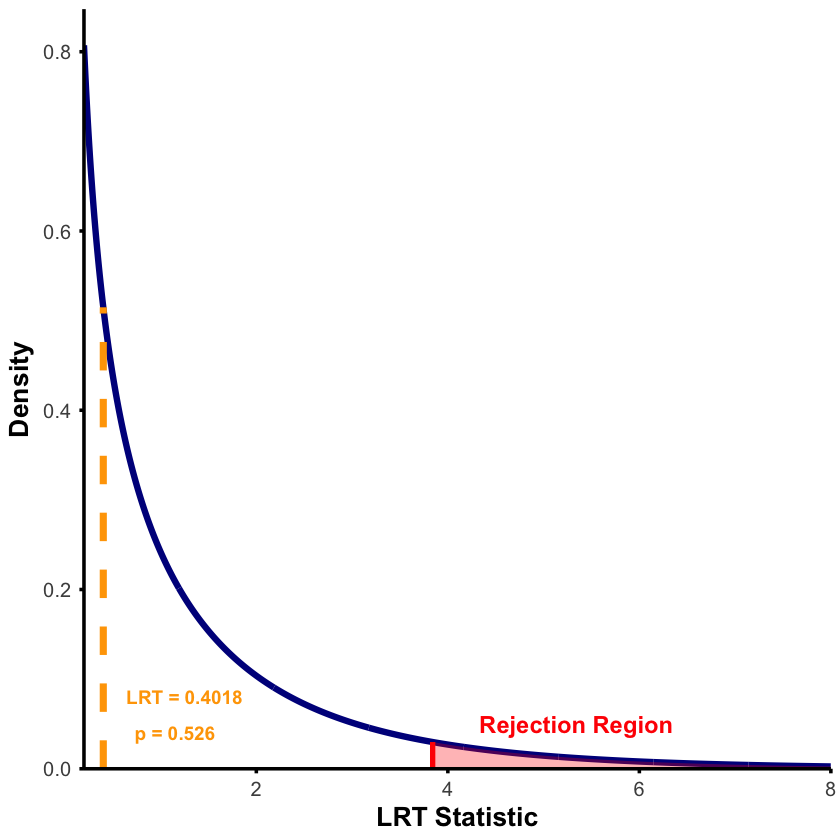

In [8]:
# Parameters
x_vals <- seq(0.2, 8, length.out = 1000)
chi_sq_density <- dchisq(x_vals, df = df)
critical_value <- qchisq(0.95, df = df)

# Data frames
df_chi <- data.frame(x = x_vals, density = chi_sq_density)
df_reject <- subset(df_chi, x >= critical_value)

# Plot
p_lrt <- ggplot(df_chi, aes(x = x, y = density)) +
  geom_line(color = "darkblue", linewidth = 1.8) +
  geom_area(data = df_reject, aes(x = x, y = density),
            fill = "red", alpha = 0.3) +
  # Critical value line
  annotate("segment", x = critical_value, xend = critical_value, 
           y = 0, yend = dchisq(critical_value, df),
           color = "red", linewidth = 1.5) +
  # Observed LRT statistic line
  annotate("segment", x = lrt_statistic, xend = lrt_statistic, 
           y = 0, yend = dchisq(lrt_statistic, df),
           color = "orange", linetype = "dashed", linewidth = 2) +
  # Labels
  annotate("text", x = lrt_statistic + 0.85, y = max(chi_sq_density) * 0.1,
           label = paste("LRT =", round(lrt_statistic, 4)), 
           color = "orange", size = 4, fontface = "bold") +
  annotate("text", x = lrt_statistic + 0.75, y = max(chi_sq_density) * 0.05,
           label = paste("p =", round(p_value, 3)), 
           color = "orange", size = 4, fontface = "bold") +
  annotate("text", x = critical_value + 1.5, y = 0.05,
           label = "Rejection Region", 
           color = "red", size = 5, fontface = "bold") +
  labs(x = expression(bold(LRT~Statistic)), 
       y = expression(bold(Density))) +
  scale_x_continuous(expand = c(0, 0)) +
  scale_y_continuous(expand = expansion(mult = c(0, 0.05))) +
  theme_minimal() +
  theme(
    text = element_text(size = 14),
    plot.title = element_text(size = 18, face = "bold", hjust = 0.5),
    axis.title.x = element_text(size = 16, face = "bold"),
    axis.title.y = element_text(size = 16, face = "bold"),
    axis.text = element_text(size = 12),
    panel.grid.major = element_blank(),
    panel.grid.minor = element_blank(),
    axis.line = element_line(linewidth = 1),
    axis.ticks = element_line(linewidth = 1),
    panel.background = element_rect(fill = "transparent", color = NA),
    plot.background = element_rect(fill = "transparent", color = NA)
  )

print(p_lrt)

In [9]:
# Save and display
ggsave("./figures/likelihood_LRT.png", plot = p_lrt, 
       width = 10, height = 6, dpi = 300, bg = "transparent")

The true effect size was $\beta = 0.4$, and our MLE correctly estimated it ($\hat{\beta} \approx 0.4$), yet the LRT failed to detect statistical significance. This illustrates the distinction between **effect size** and **statistical significance**.

The issue is **small sample size** (n=5). While the effect exists and our estimate is accurate, there's too much uncertainty to rule out random chance. Most genetic effects require hundreds or thousands of individuals to detect with statistical confidence.

A non-significant result doesn't mean no effect exists - it means insufficient data to prove the effect beyond reasonable doubt.

# Supplementary


## Graphical Summary


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




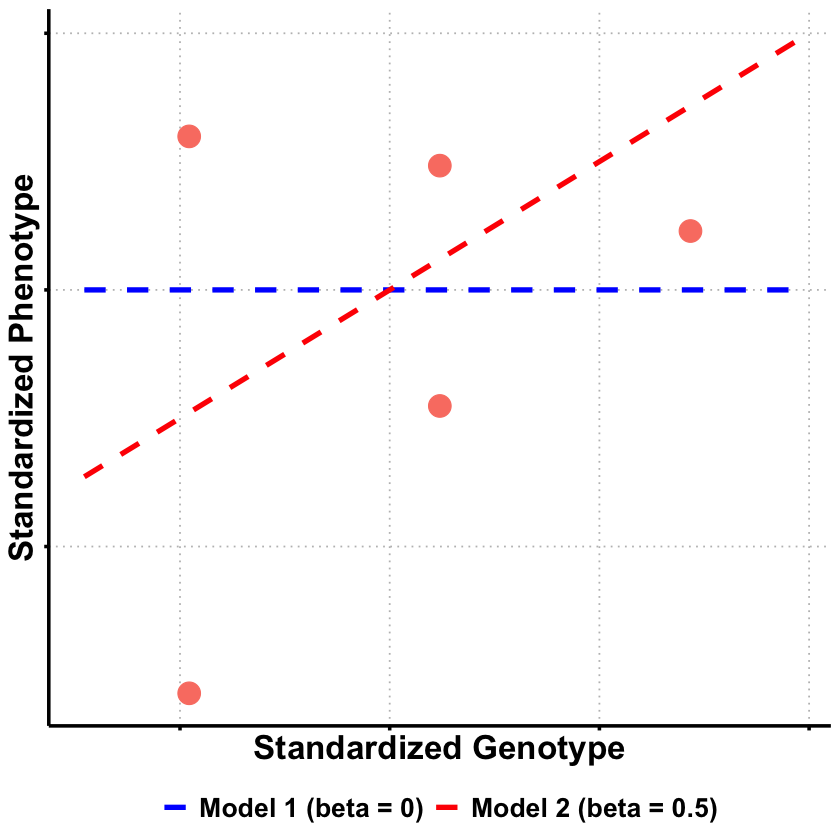

In [10]:
library(dplyr)

# Prepare the data from our analysis
df_scatter <- data.frame(
 Genotype = X,
 Phenotype = Y
)

# Create sequence for smooth lines
x_vals <- seq(min(X) - 0.5, max(X) + 0.5, length.out = 100)

# Create data frame for regression lines using Model 1 (beta=0) and Model 2 (beta=0.5)
selected_betas <- c(0, 0.5)
lines_df <- data.frame(
 Genotype = rep(x_vals, 2),
 Phenotype = c(
   selected_betas[1] * x_vals,  # Model 1: beta = 0
   selected_betas[2] * x_vals   # Model 2: beta = 0.5
 ),
 Model = factor(rep(c("Model 1 (beta = 0)", "Model 2 (beta = 0.5)"), each = length(x_vals)),
                levels = c("Model 1 (beta = 0)", "Model 2 (beta = 0.5)"))
)

# Create plot
p <- ggplot(df_scatter, aes(x = Genotype, y = Phenotype)) +
 geom_point(color = "salmon", size = 6) +
 labs(
   x = "Standardized Genotype",
   y = "Standardized Phenotype"
 ) +
 theme_minimal() +
 theme(
   text = element_text(size = 18, face = "bold"),
   axis.title = element_text(size = 20, face = "bold"),
   axis.text.x = element_blank(),
   axis.text.y = element_blank(),
   panel.grid.major = element_line(color = "gray", linetype = "dotted"),
   panel.grid.minor = element_blank(),
   axis.line = element_line(linewidth = 1),
   axis.ticks = element_line(linewidth = 1),
   panel.background = element_rect(fill = "transparent", color = NA),
   plot.background = element_rect(fill = "transparent", color = NA)
 ) +
 geom_line(data = lines_df, aes(x = Genotype, y = Phenotype, color = Model, linetype = Model), linewidth = 1.5) +
 scale_color_manual(values = c("Model 1 (beta = 0)" = "blue", "Model 2 (beta = 0.5)" = "red")) +
 scale_linetype_manual(values = c("Model 1 (beta = 0)" = "dashed", "Model 2 (beta = 0.5)" = "dashed")) +
 theme(
   legend.title = element_blank(),
   legend.position = "bottom",
   legend.text = element_text(size = 16, face = "bold")
 )

# Show and save plot
print(p)
ggsave("./figures/likelihood_ratio.png", plot = p,
      width = 6, height = 6, dpi = 300, bg = "transparent")

# Extended Reading

- [Likelihood Ratio: Wilks’s Theorem](https://stephens999.github.io/fiveMinuteStats/wilks.html) from Matthew Stephen's fiveMinuteStats 